**Notas para contenedor de docker:**

Comando de docker para ejecución de la nota de forma local:

nota: cambiar `<ruta a mi directorio>` por la ruta de directorio que se desea mapear a `/datos` dentro del contenedor de docker.

```
docker run --rm -v <ruta a mi directorio>:/datos --name jupyterlab_r_kernel_local -p 8888:8888 -d palmoreck/jupyterlab_r_kernel:1.1.0
```

password para jupyterlab: `qwerty`

Detener el contenedor de docker:

```
docker stop jupyterlab_r_kernel_local
```


Documentación de la imagen de docker `palmoreck/jupyterlab_r_kernel:1.1.0` en [liga](https://github.com/palmoreck/dockerfiles/tree/master/jupyterlab/r_kernel).

---

Esta nota utiliza métodos vistos en [1.5.Integracion_numerica](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.5.Integracion_numerica.ipynb)

In [1]:
install.packages("microbenchmark",lib="/usr/local/lib/R/site-library/",
                repos="https://cran.itam.mx/",verbose=TRUE)

system (cmd0): /usr/lib/R/bin/R CMD INSTALL

foundpkgs: microbenchmark, /tmp/RtmpgcLrgv/downloaded_packages/microbenchmark_1.4-7.tar.gz

files: /tmp/RtmpgcLrgv/downloaded_packages/microbenchmark_1.4-7.tar.gz

1): succeeded '/usr/lib/R/bin/R CMD INSTALL -l '/usr/local/lib/R/site-library' /tmp/RtmpgcLrgv/downloaded_packages/microbenchmark_1.4-7.tar.gz'



In [2]:
install.packages("tictoc",lib="/usr/local/lib/R/site-library/",
                repos="https://cran.itam.mx/",verbose=TRUE)

system (cmd0): /usr/lib/R/bin/R CMD INSTALL

foundpkgs: tictoc, /tmp/RtmpgcLrgv/downloaded_packages/tictoc_1.0.tar.gz

files: /tmp/RtmpgcLrgv/downloaded_packages/tictoc_1.0.tar.gz

1): succeeded '/usr/lib/R/bin/R CMD INSTALL -l '/usr/local/lib/R/site-library' /tmp/RtmpgcLrgv/downloaded_packages/tictoc_1.0.tar.gz'



# Parallel

Entre las herramientas más populares en R para procesamiento en paralelo están:

* [Simple Network Of Workstations: snow](https://www.rdocumentation.org/packages/snow/versions/0.4-3), ver [liga](http://homepage.divms.uiowa.edu/~luke/R/cluster/cluster.html) para más información (ya es una herramienta incluida en el paquete **parallel**).

* [multicore](https://www.rdocumentation.org/packages/future/versions/1.15.1/topics/multicore) (funciona en la familia Unix pero no en Windows y ya es una herramienta incluida en el paquete **parallel**).

* [foreach](https://www.rdocumentation.org/packages/foreach/versions/1.4.7/topics/foreach). Hay ventajas al usarse con el paquete [iterators](https://www.rdocumentation.org/packages/iterators/versions/1.0.12).

* [Rmpi](https://www.rdocumentation.org/packages/Rmpi/versions/0.6-9). Paralelización en máquinas multicore y en clústers de máquinas.

**Comentarios:**

* Las primeras dos son parte del paquete [parallel](https://www.rdocumentation.org/packages/parallel/versions/3.6.2) el cual está incluido en la instalación de R desde la versión de R 2.14.0.

* Los cuatro paquetes de arriba emplean un paradigma de programación en paralelo del tipo *scatter/gather*: se tienen múltiples instancias de R corriendo al mismo tiempo (revisar si esto es correcto para el caso de *multicore*...), ya sea en un clúster de máquinas, o en una máquina multicore. Una de las instancias se le denomina *manager*  y las restantes *workers*. El cómputo en paralelo procede como sigue:

* **scatter**: *manager* descompone el cómputo a realizar en *chunks* y envía (*scatters*) los chunks a *workers*.

* **chunk computation**: *workers* hacen el cómputo en cada *chunk* y envían de regreso los resultados a *manager*.

* **gather**: *manager* recibe (*gathers*) los resultados y los combina para resolver el problema.



## Ejemplos

### 1) Hello world!

In [3]:
library(parallel)

En el paquete *parallel* tenemos la función `detectCores` que como su nombre lo indica obtiene el número de CPU's en nuestra máquina:

In [4]:
p<-detectCores()

In [5]:
p

[1] 2

Usamos `makeCluster` para iniciar el *snow cluster*:

In [6]:
cl<-makeCluster(p)

La línea anterior crea `p` *workers* y cada *worker* es un proceso de R (como el proceso *manager*) que corren en la misma máquina.

**Comentario:** el nombre de clúster en *snow* hace referencia al conjunto de *workers* y no a máquinas físicas. El objeto `cl` contiene información de *workers* y es de clase *cluster*:

In [7]:
print(class(cl))

[1] "SOCKcluster" "cluster"    


La comunicación entre *manager* y *workers* por *default* en `makeCluster` es vía [network sockets](https://en.wikipedia.org/wiki/Network_socket) y es posible crear un clúster de máquinas físicas conectadas vía una network. 

In [8]:
cl

socket cluster with 2 nodes on host ‘localhost’

#### clusterApply

En *parallel* se tiene la función [clusterApply](https://www.rdocumentation.org/packages/parallel/versions/3.6.2/topics/clusterApply) para ejecución en paralelo de una función aplicada a cada elemento de una lista: *manager* envía `lista[1]` a `cl[1]`, `lista[2]` a `cl[2]`,...,`lista[p]` a `cl[p]`. Además, si el número de elementos de la lista es mayor que el número de *workers* entonces `clusterApply` realiza una asignación tipo *round robin*: por ejemplo, si la lista tiene $4$ elementos y se tienen $2$ *workers* entonces `clusterApply` le envía a *worker1* el elemento de la primera posición de la lista, a *worker2* el segundo elemento. Después que *worker1* finaliza el procesamiento, `clusterApply` le envía la tercera posición y al terminar *worker2* del procesamiento, `clusterApply` le envía la cuarta posición (`clusterApply` aprovecha la característica que tiene R de reciclar operaciones).

In [9]:
print(clusterApply(cl, 1:p,function(dummy)print("Hello world!")))

[[1]]
[1] "Hello world!"

[[2]]
[1] "Hello world!"



In [10]:
print(clusterApply(cl, 1:5,function(dummy)print("Hello world!")))

[[1]]
[1] "Hello world!"

[[2]]
[1] "Hello world!"

[[3]]
[1] "Hello world!"

[[4]]
[1] "Hello world!"

[[5]]
[1] "Hello world!"



**Obs:** obsérvese que el resultado de `clusterApply` es una lista.

### 2) Pasar argumentos vía `clusterExport`

`clusterExport` nos permite transmitir valores de variables definidas en el *workspace global* de *manager* hacia los *workspaces* de cada *worker* bajo los mismos nombres de variables:

In [11]:
s<-"Hola mundo!"

In [12]:
clusterExport(cl,'s')

In [13]:
print(clusterApply(cl, 1:p,function(dummy)print(s)))

[[1]]
[1] "Hola mundo!"

[[2]]
[1] "Hola mundo!"



**Comentario:** ¿qué pasa si mi `clusterExport` está dentro de una función?

In [14]:
mifun<-function(){
    s_local<-"Hola mundo! usando variable local a mifun"
    clusterExport(cl,"s_local")
    print(clusterApply(cl, 1:p,function(dummy)print(s_local)))
}

In [15]:
mifun()

ERROR: Error in get(name, envir = envir): object 's_local' not found


**¿Cómo lo resuelvo?**

Con *supperassignment*, ver [liga](https://stat.ethz.ch/pipermail/r-help/2011-April/275905.html) y [liga2](https://stackoverflow.com/questions/2628621/how-do-you-use-scoping-assignment-in-r):

In [16]:
mifun2<-function(){
    s_global<<-"Hola mundo! usando superassignment en mifun2" #<<- superassignment
    clusterExport(cl,"s_global")
    clusterApply(cl, 1:p,function(dummy)print(s_global))
}

In [17]:
print(mifun2())

[[1]]
[1] "Hola mundo! usando superassignment en mifun2"

[[2]]
[1] "Hola mundo! usando superassignment en mifun2"



O bien con `environment()`:

In [18]:
mifun3<-function(s_global2){
    clusterExport(cl,"s_global2")
    clusterApply(cl, 1:p,function(dummy)print(s_global2))
}

In [19]:
print(mifun3("Hola mundo! usando variable local a mifun3"))

ERROR: Error in get(name, envir = envir): object 's_global2' not found


In [20]:
mifun4<-function(s_global2){
    clusterExport(cl,"s_global2", envir=environment())
    clusterApply(cl, 1:p,function(dummy)print(s_global2))
}

In [21]:
print(mifun4("Hola mundo! usando environment()"))

[[1]]
[1] "Hola mundo! usando environment()"

[[2]]
[1] "Hola mundo! usando environment()"



### 3) Regla compuesta del rectángulo

In [20]:
library(microbenchmark)
library(tictoc)

In [21]:
f<-function(x)exp(-x**2)

In [22]:
a<-0
b<-1
n<-10**6
h_hat<-(b-a)/n

**Forma secuencial**

In [23]:
Rcf1<-function(f,a,b,n){
    #Compute numerical approximation using rectangle or mid-point method in 
    #an interval.
    #Nodes are generated via formula: x_i = a+(i+1/2)h_hat for i=0,1,...,n-1 and h_hat=(b-a)/n
    #Args:
    #    f (function): function of integrand
    #    a (int): left point of interval
    #    b (int): right point of interval
    #    n (int): number of subintervals
    #Returns:
    #    Rcf (float)
    h_hat<-(b-a)/n
    sum_res<-0
    for(j in 0:(n-1)){
        x<-a+(j+1/2.0)*h_hat
        sum_res<-sum_res+f(x)
    }
    h_hat*sum_res
}

In [24]:
system.time(aprox<-Rcf1(f,a,b,n))

   user  system elapsed 
  0.590   0.010   0.602 

In [25]:
err_relativo<-function(aprox,obj)abs(aprox-obj)/abs(obj)

In [26]:
obj<-integrate(Vectorize(f),a,b) #en la documentación de integrate
                                 #se menciona que se utilice Vectorize

In [27]:
err_relativo(aprox,obj$value)

[1] 6.719397e-14

In [28]:
Rcf2<-function(f,a,b,n){
    #Compute numerical approximation using rectangle or mid-point method in 
    #an interval.
    #Nodes are generated via formula: x_i = a+(i+1/2)h_hat for i=0,1,...,n-1 and h_hat=(b-a)/n
    #Args:
    #    f (function): function of integrand
    #    a (int): left point of interval
    #    b (int): right point of interval
    #    n (int): number of subintervals
    #Returns:
    #    Rcf (float)
    h_hat<-(b-a)/n
    sum_res<-0
    x<-vapply(0:(n-1),function(j)a+(j+1/2.0)*h_hat,numeric(1))
    for(j in 1:n){
        sum_res<-sum_res+f(x[j])
    }
    h_hat*sum_res
}

In [29]:
system.time(aprox<-Rcf2(f,a,b,n))

   user  system elapsed 
  1.190   0.000   1.191 

In [30]:
err_relativo(aprox,obj$value)

[1] 6.719397e-14

Una implementación que utiliza la función `sum` de `R` es la siguiente:

In [31]:
Rcf3<-function(f,a,b,n){
    #Compute numerical approximation using rectangle or mid-point method in 
    #an interval.
    #Nodes are generated via formula: x_i = a+(i+1/2)h_hat for i=0,1,...,n-1 and h_hat=(b-a)/n
    #Args:
    #    f (function): function of integrand
    #    a (int): left point of interval
    #    b (int): right point of interval
    #    n (int): number of subintervals
    #Returns:
    #    Rcf (float)
    h_hat<-(b-a)/n
    x<-vapply(0:(n-1),function(j)a+(j+1/2.0)*h_hat,numeric(1))
    h_hat*sum(f(x))
}

In [32]:
system.time(aprox<-Rcf3(f,a,b,n))

   user  system elapsed 
  0.840   0.000   0.842 

In [33]:
err_relativo(aprox,obj$value)

[1] 4.102995e-14

In [34]:
library(tictoc)

In [35]:
tic("medición de tiempo de regla de trapecio secuencial con tictoc")
tic()
Rcf1(f,a,b,n)
toc()

[1] 0.7468241

medición de tiempo de regla de trapecio secuencial con tictoc: 0.617 sec elapsed


In [36]:
mbk<-microbenchmark(
    Rcf1(f,a,b,n),
    Rcf2(f,a,b,n),
    Rcf3(f,a,b,n),
    times=10
    )

In [37]:
print(mbk)

Unit: milliseconds
             expr       min        lq      mean   median        uq       max
 Rcf1(f, a, b, n)  611.3346  614.5638  623.7536  616.686  621.0795  683.0771
 Rcf2(f, a, b, n) 1142.4681 1167.3860 1193.0945 1197.500 1216.6680 1230.3947
 Rcf3(f, a, b, n)  630.4004  632.7926  644.0145  636.963  641.5496  712.1974
 neval
    10
    10
    10


**Forma en paralelo**

Tomemos la implementación secuencial más rápida: `Rcf1` para paralelizarla:

In [38]:
ns_p<-as.integer(n/p)#número de subintervalos por proceso
                     #se asume que n es divisible por p
                     #si no se cumple esto, se puede definir 
                     #ns_p=as.integer(n/p) habiendo definido n primero
                     #y redefinir n como: 
                     #n=p*ns_p

In [39]:
sprintf("número de subintervalos: %d",n)

[1] "número de subintervalos: 1000000"

In [40]:
sprintf("número de subintervalos por proceso: %d",ns_p)

[1] "número de subintervalos por proceso: 125000"

In [41]:
Rcf_parallel<-function(mi_id){
    begin<-mi_id*ns_p
    end<-begin+ns_p
    suma_res<-0
    for(j in begin:(end-1)){
        x<-a+(j+1/2.0)*h_hat
        suma_res<-suma_res+f(x)
    }
    suma_res    
}

In [42]:
clusterExport(cl,c('ns_p','a','f','h_hat'))

Utilizamos la función `Reduce` y la función `sum` a la lista que resulta de `clusterApply`: 

In [43]:
tic("regla Rcf_parallel")
result<-clusterApply(cl,0:(p-1),Rcf_parallel)
aprox<-h_hat*Reduce(sum,result)
toc()

regla Rcf_parallel: 0.275 sec elapsed


In [44]:
err_relativo(aprox,obj$value)

[1] 3.255637e-14

La encapsulamos en una función para pasarla a `microbenchmark`:

In [45]:
clapply<-function(cl,p){
    result<-clusterApply(cl,0:(p-1),Rcf_parallel)
    aprox<-h_hat*Reduce(sum,result)
}

In [46]:
mbk<-microbenchmark(
    Rcf1(f,a,b,n),
    clapply(cl,p),
    times=10
    )

In [47]:
print(mbk)

Unit: milliseconds
             expr      min       lq     mean   median       uq      max neval
 Rcf1(f, a, b, n) 598.0952 615.7644 624.6313 619.1478 622.1897 693.5719    10
   clapply(cl, p) 173.7296 174.2377 182.0058 174.7978 180.7018 224.5982    10


### 4) Rcf utilizando `clusterSplit`

La función `clusterSplit` divide una secuencia en *chunks* de subsecuencias consecutivas. El número de *chunks* que regresa es igual al número de *workers*. `clusterSplit` intenta que los *chunks* sean similares en longitud y la división se realiza en *manager*.

En la siguiente implementación se recibe un `chunk` de nodos:

In [48]:
Rcf_parallel2<-function(chunk){
    #Únicamente se acumula el valor de f en el nodo:
    suma_res<-0
    for(x in chunk){
        suma_res<-suma_res+f(x)
    }
    suma_res    
}

In [49]:
tic()
#se crean los chunks del conjunto de nodos:
chunks<-clusterSplit(cl,vapply(0:(n-1),function(j)a+(j+1/2.0)*h_hat,numeric(1))) 
result<-clusterApply(cl,chunks,Rcf_parallel2)
aprox<-h_hat*Reduce(sum,result)
toc()

0.919 sec elapsed


In [50]:
err_relativo(aprox,obj$value)

[1] 3.359699e-14

En la siguiente implementación, se divide en chunks la secuencia: `0,1,...,n-1`:

In [51]:
Rcf_parallel3<-function(chunk){
    ns_p<-length(chunk)
    begin<-chunk[1]
    end<-begin+ns_p
    suma_res<-0
    for(j in begin:(end-1)){
        x<-a+(j+1/2.0)*h_hat
        suma_res<-suma_res+f(x)
    }
    suma_res    
}

In [52]:
tic()
#se crean los chunks de la secuencia: 0,1,...,n-1
chunks<-clusterSplit(cl,0:(n-1)) 
result<-clusterApply(cl,chunks,Rcf_parallel3)
aprox<-h_hat*Reduce(sum,result)
toc()

0.261 sec elapsed


In [53]:
err_relativo(aprox,obj$value)

[1] 3.359699e-14

Medimos tiempos con `microbenchmark`:

In [54]:
clapply2<-function(cl){
    chunks<-clusterSplit(cl,vapply(0:(n-1),function(j)a+(j+1/2.0)*h_hat,numeric(1))) 
    result<-clusterApply(cl,chunks,Rcf_parallel2)
    aprox<-h_hat*Reduce(sum,result)
}

In [55]:
clapply3<-function(cl){
    chunks<-clusterSplit(cl,0:(n-1))
    result<-clusterApply(cl,chunks,Rcf_parallel3)
    aprox<-h_hat*Reduce(sum,result)
}

In [56]:
mbk<-microbenchmark(
    Rcf1(f,a,b,n),
    clapply(cl,p),
    clapply2(cl),
    clapply3(cl),
    times=10
    )

In [57]:
print(mbk)

Unit: milliseconds
             expr      min       lq     mean   median       uq       max neval
 Rcf1(f, a, b, n) 594.8892 610.0890 619.8617 614.1308 625.8948  674.3433    10
   clapply(cl, p) 171.9395 173.7119 176.9586 174.7444 176.5444  198.2448    10
     clapply2(cl) 908.2237 913.5611 950.3876 931.8672 935.4245 1106.1972    10
     clapply3(cl) 247.4217 256.5972 269.7200 266.2207 287.8739  297.8516    10


## Gráfica de tiempo de ejecución vs número de procesos

In [58]:
library(ggplot2)

**Nota: los siguientes resultados se obtuvieron con una máquina con 8 cores, así que pueden no coincidir con los resultados previos de esta sección.**

**Una buena práctica es detener el clúster, observar que en la documentación se menciona:** It is good practice to shut down the workers by calling stopCluster: however the workers will terminate themselves once the socket on which they are listening for commands becomes unavailable, which it should if the master R session is completed (or its process dies).

In [59]:
stopCluster(cl)

En lo siguiente se utiliza `Rcf_parallel` pues tuvo el menor tiempo de ejecución. Usaremos ésta implementación para realizar la gráfica variando el número de procesos de $1$ hasta `detectCores()`.

In [60]:
Rcf_parallel<-function(mi_id){
    begin<-mi_id*ns_p
    end<-begin+ns_p
    suma_res<-0
    for(j in begin:(end-1)){
        x<-a+(j+1/2.0)*h_hat
        suma_res<-suma_res+f(x)
    }
    suma_res    
}

In [61]:
n<-10**6 #cambiar n si se desea
h_hat<-(b-a)/n

In [62]:
mifun<-function(cl,p,ns_p){
    result<-clusterApply(cl,0:(p-1),Rcf_parallel)
    aprox<-h_hat*Reduce(sum,result)
    err_relativo(aprox,obj$value)
}

In [63]:
dim<-sum(n%%(1:detectCores())==0)

In [64]:
err_np<-vector("double", dim)
n_cpus<-vector("integer",dim)

In [65]:
i<-1
for(p in 1:detectCores()){
    if(n%%p==0){
        ns_p<-n/p
        cl<-makeCluster(p)
        clusterExport(cl,c('a','f','h_hat','ns_p'))
        err_np[i]<-mifun(cl,p,ns_p)
        n_cpus[i]<-p
        stopCluster(cl)
        i<-i+1
    }
}

In [66]:
print(err_np)

[1] 6.719397e-14 5.842308e-14 4.816559e-14 5.024682e-14 3.255637e-14


In [67]:
print(n_cpus)

[1] 1 2 4 5 8


In [68]:
v<-vector("double", dim)
n_cpus<-vector("integer",dim)

In [69]:
i<-1
for(p in 1:detectCores()){
    if(n%%p==0){
        ns_p<-n/p
        cl<-makeCluster(p)
        clusterExport(cl,c('a','f','h_hat','ns_p'))
        df<-print(microbenchmark(mifun(cl,p,ns_p),times=10,unit="s"))
        stopCluster(cl)
        v[i]<-df$median
        n_cpus[i]<-p
        i<-i+1
    }
}

Unit: seconds
               expr       min        lq     mean    median        uq      max
 mifun(cl, p, ns_p) 0.6914707 0.6963938 0.721669 0.7110445 0.7280059 0.783008
 neval
    10
Unit: seconds
               expr      min        lq      mean    median        uq      max
 mifun(cl, p, ns_p) 0.358746 0.3624429 0.3711393 0.3640568 0.3661319 0.427689
 neval
    10
Unit: seconds
               expr       min        lq      mean    median        uq       max
 mifun(cl, p, ns_p) 0.1953516 0.1970122 0.2140039 0.2002072 0.2221021 0.2637789
 neval
    10
Unit: seconds
               expr       min        lq      mean    median        uq      max
 mifun(cl, p, ns_p) 0.1955969 0.1980711 0.2127985 0.2003324 0.2091672 0.270982
 neval
    10
Unit: seconds
               expr       min        lq      mean    median        uq       max
 mifun(cl, p, ns_p) 0.1727074 0.1765104 0.1926165 0.1788327 0.1941469 0.2668926
 neval
    10


In [70]:
print(v)

[1] 0.7110445 0.3640568 0.2002072 0.2003324 0.1788327


In [71]:
print(n_cpus)

[1] 1 2 4 5 8


In [72]:
gg<-ggplot()

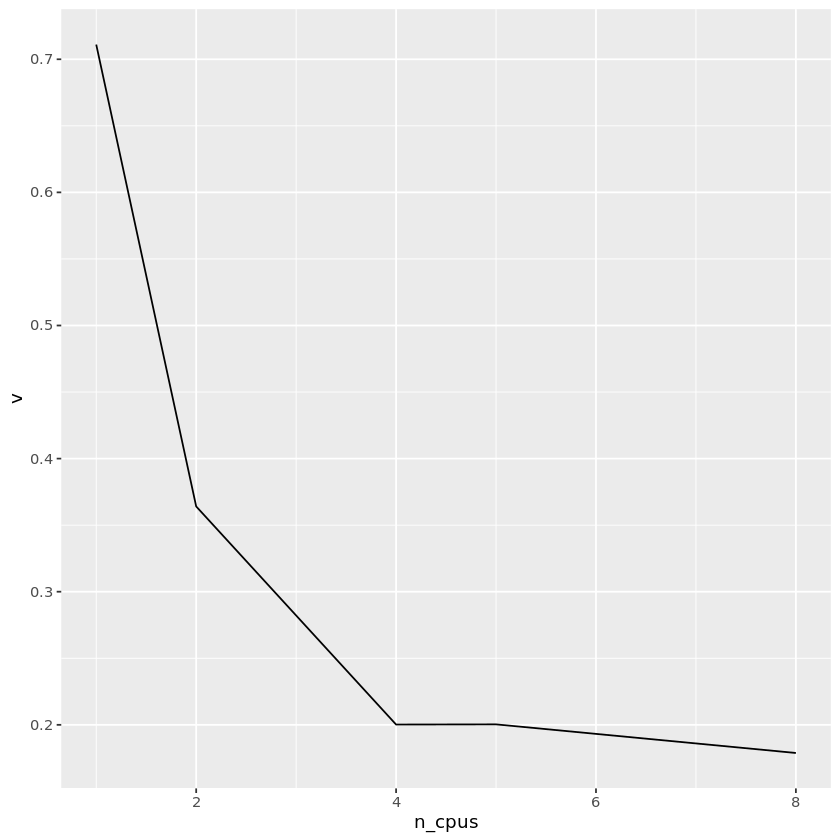

In [73]:
gg+
geom_line(aes(x=n_cpus,y=v))

**Ejercicio:** elegir regla de Simpson o integración por el método de Monte Carlo para generar la gráfica anterior. No olviden medir errores relativos. Tales reglas están en [1.5.Integracion_numerica](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.5.Integracion_numerica.ipynb), 

Si eligieron regla de Simpson: 

* Medir tiempo de las $3$ versiones, por ejemplo, para el caso del rectángulo se tienen Rcf, Rcf_parallel, Rcf_parallel2, Rcf_parallel3.

* Elegir la mejor versión en medición del tiempo de ejecución y variar el número de procesadores. Aquí se miden errores relativos y se hace la gráfica de número de cpus vs tiempo.


**Referencias:**

1. N. Matloff, Parallel Computing for Data Science. With Examples in R, C++ and CUDA, 2014.

2. [2.1.Un_poco_de_historia_y_generalidades](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.1.Un_poco_de_historia_y_generalidades.ipynb)

3. [2.2.Sistemas_de_memoria_compartida.ipynb](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/II.computo_paralelo/2.2.Sistemas_de_memoria_compartida.ipynb)

Otras referencias:

* [snow Simplified](http://www.sfu.ca/~sblay/R/snow.html)

* [Using foreach and iterators for manual parallel execution](https://docs.microsoft.com/en-us/machine-learning-server/r/how-to-revoscaler-distributed-computing-foreach)

Otro paquete a revisar:

* [future](https://www.rdocumentation.org/packages/future/versions/1.16.0)